In [1]:
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize

In [22]:
date = "2022-03-22"

def gc_key(file):
    PR_str = file.split("/")[-2].split("-")
    return int(PR_str[1]), int(PR_str[3])

files = sorted(glob.glob(f"../nextflow/results/{date}/gctrees/PR*/gctree.p"), key=gc_key)
trees = {"_".join(f"{x}{y}" for x, y in zip(("mouse", "GC"), gc_key(file))): pickle.load(open(file, "rb"))
         for file in files}

print(f"loaded {len(trees)} GC trees")

loaded 74 GC trees


In [23]:
df = pd.DataFrame()

for row, (mouse_gc, tree) in enumerate(trees.items()):
    mouse, gc = mouse_gc.split("_")
    mouse = mouse.lstrip("mouse")
    if mouse in ("7", "8"):
        print(f"skipping 10-week {mouse_gc}")
        continue
    if sum(node.abundance for node in tree.tree.traverse()) < 20:
        print(f"skipping low-abundance {mouse_gc}")
        continue
    if sum(node.abundance for node in tree.tree.traverse()) > 96:
        print(f"skipping duplicate-barcode {mouse_gc}")
        continue
    
    gc = gc.lstrip("GC")
    df.loc[row, "mouse"] = mouse
    df.loc[row, "GC"] = gc
    
    abundances = np.array([node.abundance for node in tree.tree.traverse()])
    df.loc[row, "abundance CoV"] = abundances.std() / abundances.mean()
    df.loc[row, "max abundance fraction"] = abundances.max() / abundances.sum()

    clade_sizes = [sum(node.abundance for node in child.traverse()) for child in tree.tree.children]
    df.loc[row, "normalized dominance score"] = max(clade_sizes) / sum(clade_sizes)

#     tree.local_branching(tau=1, tau0=0.1)
    df.loc[row, f"max LBI"] = np.nanmax([node.LBI for node in tree.tree.traverse()])
    df.loc[row, f"max LBR"] = np.nanmax([node.LBR for node in tree.tree.traverse()])

df

skipping low-abundance mouse1_GC11
skipping low-abundance mouse1_GC12
skipping low-abundance mouse2_GC28
skipping low-abundance mouse2_GC29
skipping low-abundance mouse2_GC39
skipping low-abundance mouse3_GC41
skipping low-abundance mouse3_GC64
skipping low-abundance mouse3_GC65
skipping low-abundance mouse4_GC63
skipping 10-week mouse7_GC90
skipping 10-week mouse8_GC84
skipping 10-week mouse8_GC85
skipping 10-week mouse8_GC86
skipping 10-week mouse8_GC87
skipping 10-week mouse8_GC88
skipping 10-week mouse8_GC89


,mouse,GC,abundance CoV,max abundance fraction,normalized dominance score,max LBI,max LBR
0,1,1,0.833973,0.069767,0.930233,18.510031,4.531324
1,1,2,0.599632,0.037736,0.981132,17.259861,8.288814
2,1,3,1.517881,0.168675,0.831325,15.534970,11.259033
3,1,4,0.629213,0.040541,0.689189,25.096196,4.957376
4,1,5,0.593330,0.023810,0.476190,27.115099,6.210957
5,1,6,0.521119,0.036585,0.536585,15.591827,10.859881
6,1,7,1.348168,0.185185,0.777778,13.970386,6.138965
9,1,13,0.702343,0.045455,1.000000,17.433807,7.999255
10,1,14,0.622700,0.035714,0.452381,14.224065,4.643905
11,1,15,0.680961,0.050633,0.949367,18.108497,9.463747


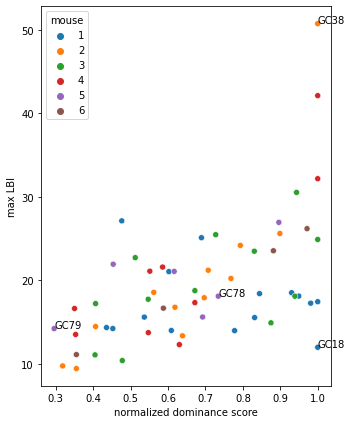

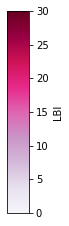

In [26]:
cmap = "PuRd"
vmin = 0
vmax = 30

fig = plt.figure(figsize=(5, 6))
sns.scatterplot(data=df, x="normalized dominance score", y="max LBI", hue="mouse", clip_on=False)
for i, row in df.iterrows():
    x, y = row[["normalized dominance score", "max LBI"]]
    if (x == 1 and (y > 45 or y < 15)) or x < 0.3 or row.GC == "78":
        plt.annotate(f"GC{row.GC}", [x, y])
        key = f"mouse{row.mouse}_GC{row.GC}"
        colormap = trees[key].feature_colormap("LBI", vmin=vmin, vmax=vmax, cmap=cmap)
        trees[key].render(f"output/plots/NDS_LBI.{key}.svg", colormap=colormap, scale=20, branch_margin=-8)
plt.tight_layout()
plt.savefig("output/plots/NDS_LBI.pdf")
plt.show()
fig = plt.figure()
cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
plt.colorbar(cm.ScalarMappable(cmap=cmap, norm=Normalize(vmin=vmin, vmax=vmax)), cax=cax, label="LBI")
plt.savefig("output/plots/NDS_LBI.cbar.pdf")
plt.show()